# Assignment1 by Aubakirov Sultan

For this assignment you will use Fruits and Vegetables Image Recognition Dataset: 
https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

## 1) Load and preprocess the given dataset

In [ ]:
!pip  install kaggle

In [ ]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition
!unzip fruit-and-vegetable-image-recognition.zip

Installing all libraries, i've decide to use pytorch library

In [6]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision import utils
import os
from PIL import Image
from tqdm import tqdm
import time
import torch.nn.init as init

Constants:

In [4]:
image_size = 224
batch = 64
num_workers = 4
learning_rate = 0.001
num_epochs = 30
num_classes = 36
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now when data is installed it should be preprocessed

## 2) Data Augmentation

In [4]:
train_data = ImageFolder('train')
print(train_data.classes)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [ ]:
for dir_name in ['test', 'train', 'validation']:
    original_data_path = dir_name
    augmented_data_path = f'augmented_{dir_name}'
    num_of_copies = 3

    augment_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ])

    dataset = ImageFolder(root=original_data_path)
    
    os.makedirs(augmented_data_path, exist_ok=True)

    for i, (img, label) in enumerate(dataset):
        class_name = dataset.classes[label]
        class_dir = os.path.join(augmented_data_path, class_name)
        os.makedirs(class_dir, exist_ok=True)
        print(os.path.join(class_dir, f'Image_{i + 1}.png'))
        img.save(os.path.join(class_dir, f'Image_{i + 1}.png'))
        for j in range(num_of_copies):
            augmented_img = augment_transform(img)
            
            save_path = os.path.join(class_dir, f'Image_{i + 1}_{j + 1}.png')

            augmented_img.save(save_path)
        print(class_name, " - image added succesfully")

print("Augmented images saved")


In [68]:
torch.cuda.is_available()


True

## 3) Data preprocessing

In [7]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Изменение размера изображений на 224x224
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # AlexNet normalization
])


train_data = ImageFolder('augmented_train', transform=transform)
val_data = ImageFolder('augmented_validation', transform=transform)
test_data = ImageFolder('augmented_test', transform=transform)


train_loader = DataLoader(train_data, batch_size=30, shuffle=True)
val_loader = DataLoader(val_data, batch_size=30, shuffle=False)
test_loader = DataLoader(test_data, batch_size=30, shuffle=False)



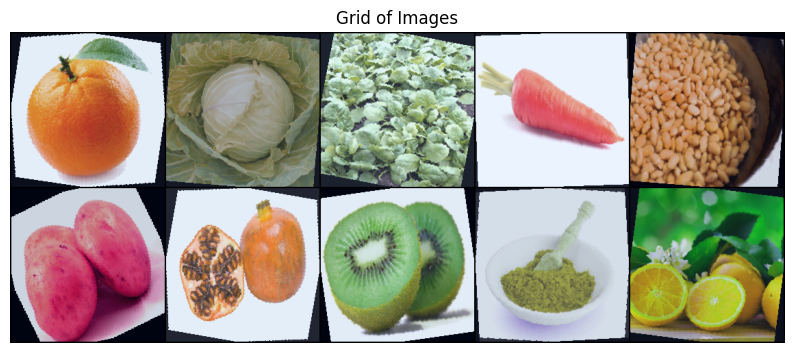

In [11]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
grid = utils.make_grid(images[:10], nrow=5, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy()) 
plt.axis('off')
plt.title('Grid of Images')
plt.show()


## 4) Training of models

In [ ]:
def train_model(model):
    criteria = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-4)

    
    train_loss = []
    val_loss = []
    
    test_loss_min = np.inf
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criteria(output, target)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * data.size(0)
                _, predicted = output.max(1)
                correct += predicted.eq(target).sum().item()
                
                pbar.update(1)
                pbar.set_postfix({'loss': loss.item()})
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100. * correct / len(train_loader.dataset)

        test_loss = 0
        correct = 0
        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criteria(output, target)
                test_loss += loss.item() * data.size(0)
                _, predicted = output.max(1)
                correct += predicted.eq(target).sum().item()
        
        test_loss /= len(val_loader.dataset)
        test_accuracy = 100. * correct / len(val_loader.dataset)
        
        print(f'Epoch: {epoch + 1}, Training Loss: {train_loss:.6f}, Training Acc: {train_accuracy:.2f}%, Testing Loss: {test_loss:.6f}, Testing Acc: {test_accuracy:.2f}%')
        
        if test_loss < test_loss_min:
            print(f'Test loss decreased ({test_loss_min:.6f} --> {test_loss:.6f}). Saving model...')
            torch.save(model.state_dict(), model.__class__.__name__ + '_model_123.pt')
            test_loss_min = test_loss


        time_elapsed = time.time() - start_time
        estimated_time = (time_elapsed / (epoch + 1)) * (num_epochs - (epoch + 1))
        print(f'Time Elapsed: {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')
        print(f'Estimated Time Remaining: {int(estimated_time // 60)}m {int(estimated_time % 60)}s')

## Implement a CNN with proper architecture. Describe your implementation and explain why you choose such architecture

### My own architecture SultanCNN

In [4]:
class SultanCNN(nn.Module):
    def __init__(self):
        super(SultanCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Первый сверточный слой
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling для уменьшения размерности
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Второй сверточный слой
        self.bn2 = nn.BatchNorm2d(32)  # Batch Norm только после второго сверточного слоя
        # Полносвязный слой, принимающий вход размером (32 * 56 * 56)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Линейный fully connected layer
        self.fc2 = nn.Linear(128, len(train_data.classes))  # Второй полносвязный слой для выхода

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Первый сверточный слой -> Max Pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Второй сверточный слой -> Batch Norm -> Max Pooling
        x = x.view(-1, 32 * 56 * 56)  # Преобразуем тензор в вектор (Flatten)
        x = F.relu(self.fc1(x))  # Применение ReLU после первого полносвязного слоя
        x = self.fc2(x)  # Выходной слой
        return x

# Инициализация
sultan = SultanCNN()


Training model

In [ ]:
sultan.to(device)

train_model(sultan)

In [ ]:
# save model
torch.save(sultan, 'SultanCNN-model.pt')

### AlexNET pretrained model 

![AlexNet](alex_design.png "Title")

Source: M. Hayashi-Nishino et al., “Identification of bacterial Drug-Resistant cells by the convolutional neural network in transmission electron microscope images,” Frontiers in Microbiology, vol. 13, Mar. 2022, doi: 10.3389/fmicb.2022.839718.

In [8]:
alexNet = models.alexnet(pretrained=True)

alexNet.classifier[6] = nn.Linear(4096, num_classes) # replacing last layer for training


C:\Users\test\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\test\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

alexNet = AlexNet()

This is architecture of AlexNet used in pytorch. It is has additional average pooling layer.

In [ ]:
alexNet.to(device)

train_model(alexNet)

In [ ]:
torch.save(alexCNN, 'AlexNet-predtrained-model.pt')

### AlexNet with Sigmoid functions

In [5]:
class AlexNetSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.Sigmoid(),
            
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.Sigmoid(),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.Sigmoid(),
            
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    

This model will have terrible results due to vanishing gradient problem that often occurs while using Sigmoid and Tanh

In [ ]:
alex_sigma = AlexNetSigmoid(num_classes)

alex_sigma.to(device)

train_model(alex_sigma)

In [6]:
torch.save(alex_sigma, 'AlexNet-sigma-model.pt')

### Small random numbers and Xavier

In [6]:
class SmallRandomNet(AlexNet):
    def __init__(self):
        super(SmallRandomNet, self).__init__()
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)  
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class XavierNet(AlexNet):
    def __init__(self):
        super(XavierNet, self).__init__()
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

I just use already created structure, only changing weight initialization

In [ ]:
small_random_model = SmallRandomNet().to(device)
xavier_model = XavierNet().to(device)

train_model(small_random_model)
train_model(xavier_model)

In [ ]:
torch.save(xavier_model, 'Xavier-model.pt')
torch.save(small_random_model, 'Small-random-model.pt')

### Batch and Dropout Regularizations

In [7]:
class AlexNetWithReg(nn.Module):
    def __init__(self):
        super(AlexNetWithReg, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
regularization_model = AlexNetWithReg().to(device)

train_model(regularization_model)

In [ ]:
torch.save(regularization_model, 'Regularization_model.pt')


## Evaluating models

In [12]:
model_files = {
    'AlexNet': 'AlexNet_model.pt',
    'AlexNetSigmoid': 'AlexNet-sigma-model.pt',
    'XavierNet': 'Xavier_model.pt',
    'SmallRandomNet': 'Small-random-model.pt',
    'AlexNetWithReg': 'Regularization_model.pt'
}

# Load models
models = {}
for name, path in model_files.items():
    model = (eval(f"{name}()"))
    model.load_state_dict(torch.load(path))
    model.eval() 
    models[name] = model
    print(f'{name} loaded successfully.')

AlexNet loaded successfully.
AlexNetSigmoid loaded successfully.
XavierNet loaded successfully.
SmallRandomNet loaded successfully.
AlexNetWithReg loaded successfully.


In [18]:
def test_model(model, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    average_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return average_loss, accuracy

test_results = []

for model in models.values():
    model.to(device)
    test_loss, test_accuracy = test_model(model, test_loader)
    test_results.append({
        'model_name': model.__class__.__name__,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    })

test_results_df = pd.DataFrame(test_results)

print(test_results_df)



       model_name  test_loss  test_accuracy
0         AlexNet   0.322670      90.250696
1  AlexNetSigmoid   3.601111       2.785515
2       XavierNet   0.237698      94.707521
3  SmallRandomNet   0.393010      89.693593
4  AlexNetWithReg   0.169380      95.821727


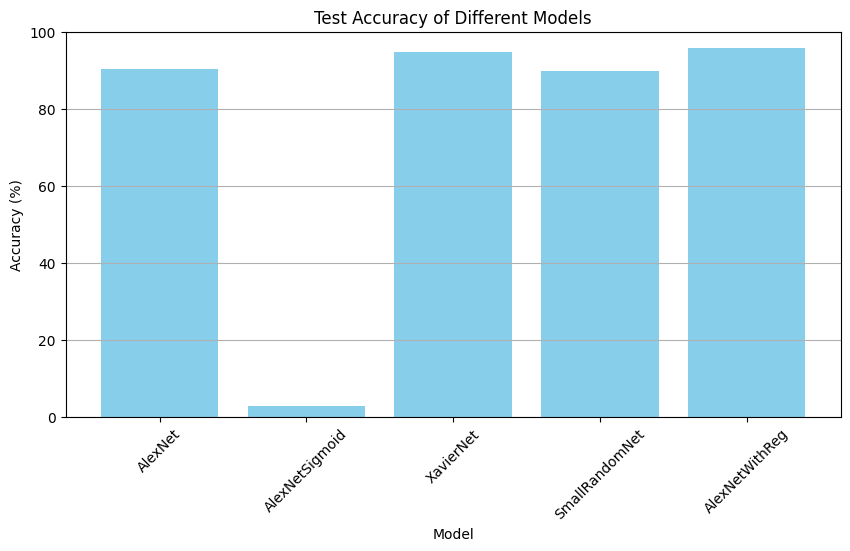

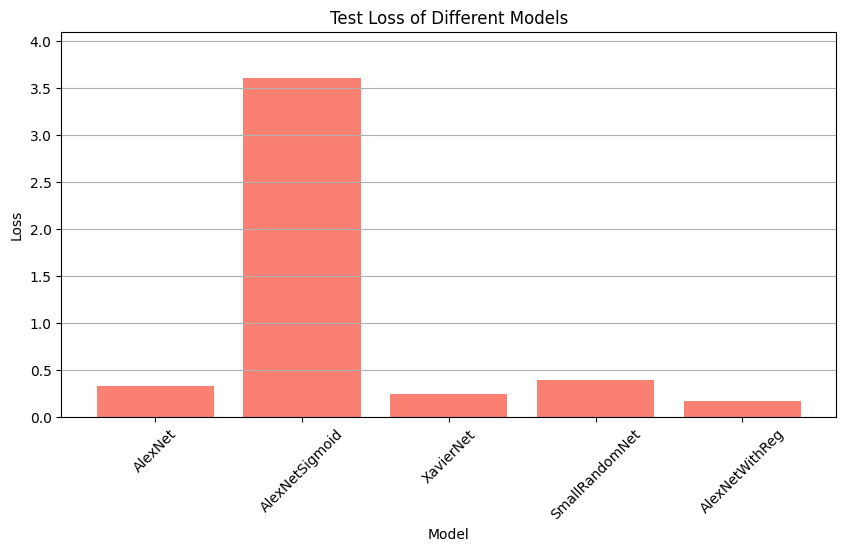

In [19]:
plt.figure(figsize=(10, 5))
plt.bar(test_results_df['model_name'], test_results_df['test_accuracy'], color='skyblue')
plt.title('Test Accuracy of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(test_results_df['model_name'], test_results_df['test_loss'], color='salmon')
plt.title('Test Loss of Different Models')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.ylim(0, max(test_results_df['test_loss']) + 0.5)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Assignment 2

## AlexNET fine tuning on augmented data

In [7]:
alex_net = AlexNet()
alex_net.load_state_dict(torch.load('AlexNet_model.pt'))
for param in alex_net.parameters():
    param.requires_grad = False

for param in alex_net.classifier[6].parameters():
    param.requires_grad = True

for name, param in alex_net.named_parameters():
    print(f'{name}: {param.requires_grad}')



features.0.weight: False
features.0.bias: False
features.3.weight: False
features.3.bias: False
features.6.weight: False
features.6.bias: False
features.8.weight: False
features.8.bias: False
features.10.weight: False
features.10.bias: False
classifier.1.weight: False
classifier.1.bias: False
classifier.4.weight: False
classifier.4.bias: False
classifier.6.weight: True
classifier.6.bias: True


In [8]:
alex_net.to(device)
train_model(alex_net)

Epoch 1/30:   2%|▏         | 2/104 [00:14<10:36,  6.24s/batch, loss=3.81]C:\Users\test\AppData\Roaming\Python\Python38\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/30: 100%|██████████| 104/104 [03:33<00:00,  2.05s/batch, loss=2.42]


Epoch: 1, Training Loss: 2.592409, Training Acc: 40.77%, Testing Loss: 1.650182, Testing Acc: 54.42%
Test loss decreased (inf --> 1.650182). Saving model...
Time Elapsed: 4m 0s
Estimated Time Remaining: 116m 14s


Epoch 2/30: 100%|██████████| 104/104 [04:04<00:00,  2.35s/batch, loss=2.52]


Epoch: 2, Training Loss: 2.104535, Training Acc: 44.40%, Testing Loss: 1.508784, Testing Acc: 59.26%
Test loss decreased (1.650182 --> 1.508784). Saving model...
Time Elapsed: 8m 32s
Estimated Time Remaining: 119m 29s


Epoch 3/30: 100%|██████████| 104/104 [03:07<00:00,  1.81s/batch, loss=1.35]


Epoch: 3, Training Loss: 2.026629, Training Acc: 45.87%, Testing Loss: 1.454700, Testing Acc: 56.98%
Test loss decreased (1.508784 --> 1.454700). Saving model...
Time Elapsed: 12m 6s
Estimated Time Remaining: 108m 55s


Epoch 4/30: 100%|██████████| 104/104 [03:32<00:00,  2.04s/batch, loss=2.65]


Epoch: 4, Training Loss: 2.037182, Training Acc: 45.75%, Testing Loss: 1.398048, Testing Acc: 58.97%
Test loss decreased (1.454700 --> 1.398048). Saving model...
Time Elapsed: 16m 6s
Estimated Time Remaining: 104m 40s


Epoch 5/30: 100%|██████████| 104/104 [03:31<00:00,  2.04s/batch, loss=2.12]


Epoch: 5, Training Loss: 2.053565, Training Acc: 46.61%, Testing Loss: 1.426247, Testing Acc: 60.40%
Time Elapsed: 20m 5s
Estimated Time Remaining: 100m 27s


Epoch 6/30: 100%|██████████| 104/104 [04:35<00:00,  2.65s/batch, loss=2.08]


Epoch: 6, Training Loss: 1.989962, Training Acc: 47.22%, Testing Loss: 1.397968, Testing Acc: 61.25%
Test loss decreased (1.398048 --> 1.397968). Saving model...
Time Elapsed: 25m 11s
Estimated Time Remaining: 100m 46s


Epoch 7/30: 100%|██████████| 104/104 [03:50<00:00,  2.21s/batch, loss=1.73]


Epoch: 7, Training Loss: 1.951746, Training Acc: 48.03%, Testing Loss: 1.275513, Testing Acc: 64.39%
Test loss decreased (1.397968 --> 1.275513). Saving model...
Time Elapsed: 29m 31s
Estimated Time Remaining: 96m 59s


Epoch 8/30: 100%|██████████| 104/104 [03:34<00:00,  2.06s/batch, loss=1.6] 


Epoch: 8, Training Loss: 1.865769, Training Acc: 48.89%, Testing Loss: 1.207010, Testing Acc: 63.25%
Test loss decreased (1.275513 --> 1.207010). Saving model...
Time Elapsed: 33m 34s
Estimated Time Remaining: 92m 19s


Epoch 9/30: 100%|██████████| 104/104 [03:38<00:00,  2.10s/batch, loss=1.7] 


Epoch: 9, Training Loss: 1.904415, Training Acc: 48.25%, Testing Loss: 1.426888, Testing Acc: 62.39%
Time Elapsed: 37m 38s
Estimated Time Remaining: 87m 50s


Epoch 10/30:   8%|▊         | 8/104 [00:27<05:28,  3.43s/batch, loss=2.84]


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 18063360 bytes.